# Convergency checks
In this model, we use ArviZ to check if our model has converged.

In [1]:
import sys
sys.path.append('../src/')

import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from utils.data_utils import load_data
from utils.plot_utils import set_plot_defaults
from utils.convergence_utils import check_mcse, check_neff, check_rhat

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
set_plot_defaults(font="Europace Sans")
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
d, zip_lookup, num_zip_codes = load_data(kind="prices")   # loads data from data/interim_data/houses.csv 
                                                          # aternatively, use kind="rents" to load data from data/interim_data/rent.csv
zip_codes = np.sort(d.zip.unique())
target = "price_s"

We will check both the centered hierarchical model as well as the bad model, just to see how a model looks like that did not converge.

In [3]:
data = az.from_netcdf("../models/centered_hier.nc")
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data
	> constant_data

In [4]:
bad_data = az.from_netcdf("../models/bad_model.nc")

In [5]:
az.summary(data.posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.642,0.057,3.527,3.741,0.001,0.001,5524.0,5524.0,5535.0,3184.0,1.0
mu_beta,2.775,0.099,2.596,2.966,0.001,0.001,5782.0,5781.0,5766.0,3343.0,1.0
alpha[0],4.976,0.161,4.688,5.289,0.002,0.002,5618.0,5590.0,5626.0,3249.0,1.0
alpha[1],5.097,0.289,4.545,5.616,0.004,0.003,6018.0,6018.0,6017.0,3309.0,1.0
alpha[2],5.128,0.201,4.731,5.483,0.002,0.002,7223.0,7223.0,7272.0,3517.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[217],2.668,1.280,0.290,4.958,0.014,0.012,7809.0,5449.0,7833.0,2742.0,1.0
beta[218],0.504,0.792,-0.999,1.999,0.009,0.011,7653.0,2519.0,7656.0,3127.0,1.0
sigma_alpha,0.741,0.044,0.664,0.830,0.001,0.000,4491.0,4491.0,4466.0,3015.0,1.0
sigma_beta,1.274,0.071,1.146,1.415,0.001,0.001,4779.0,4779.0,4726.0,3035.0,1.0


## Trace plots
The first thing to check to see if a model converged or not are the trace plots. If you have more than 2 chains, it can be a good idea to only look at two, otherwise the plots can get very crowded.

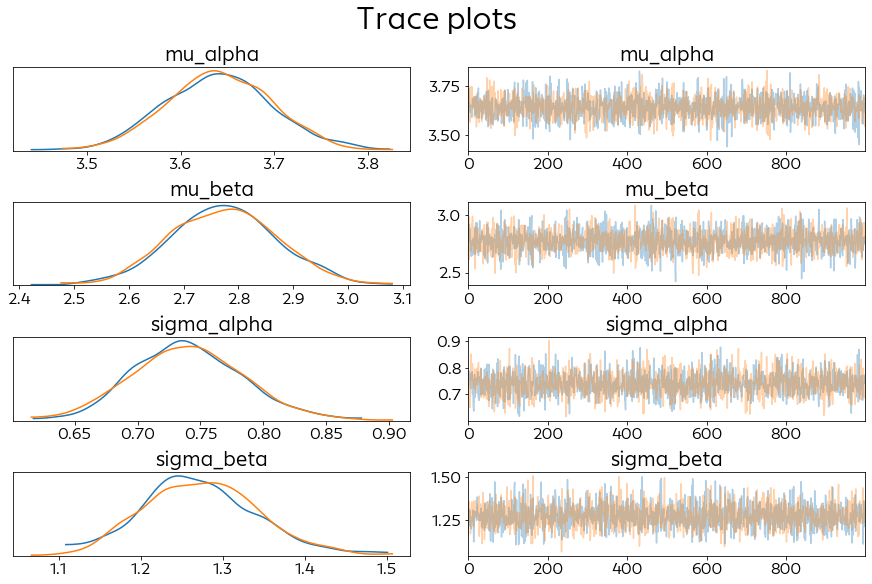

In [6]:
az.plot_trace(data, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta"],
             coords={"chain":[0,1]})
plt.suptitle("Trace plots")
plt.show()

These trace plots look goot but we only look here at a selection of parameters. Remember that for each ZIP code, we fit both an $\alpha$ and $\beta$ parameter.
This means we actually have hundreds of parameter and we cannot feasibly plot all of them and look at all of them.

## Rhat statistic
The Rhat statistic measures how similar the different chains are. So to be able to compute it, we need at least two chains. If all chains converged to the same distribution, then the Rhat statistic should be close to 1.
An Rhat greater than 1.1 means something is very wrong and your model did not converge (in this case, PyMC3 will also raise some warnings). However, already a value above 1.01 is reason for concern, so when computing it via the summary function from ArviZ, it is best to deactive rounding.

In [7]:
s = az.summary(data, round_to="none")
s.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.641892,0.056519,3.526990,3.741161,0.000760,0.000538,5523.662786,5523.662786,5534.529199,3184.033781,1.000298
mu_beta,2.774866,0.099303,2.595929,2.965907,0.001306,0.000924,5782.110792,5780.776788,5765.617689,3343.464957,1.000784
alpha[0],4.976080,0.160512,4.687661,5.288980,0.002142,0.001518,5617.647832,5590.325691,5626.214679,3249.134036,1.000693
alpha[1],5.096531,0.289015,4.544702,5.616254,0.003726,0.002634,6018.064316,6018.064316,6017.194491,3308.938699,1.000847
alpha[2],5.127996,0.201097,4.730814,5.483099,0.002366,0.001673,7223.462402,7223.462402,7271.583124,3517.120722,0.999774


I built a small convenience function that plots a histogram of the Rhat over all parameters and also tells you which parameters (if any) are above a certain threshold. This way, we can then analyse these parameters further.

The following parameters have an Rhat greater 1.05:
None



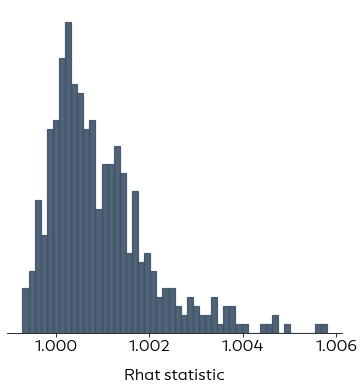

In [8]:
check_rhat(data, threshold=1.05)
plt.show()

The following parameters have an Rhat greater 1.005:
['alpha[205]', 'beta[191]']



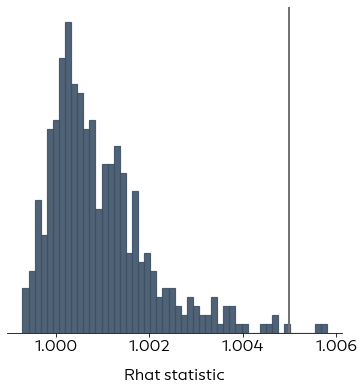

In [9]:
check_rhat(data, threshold=1.005)
plt.show()

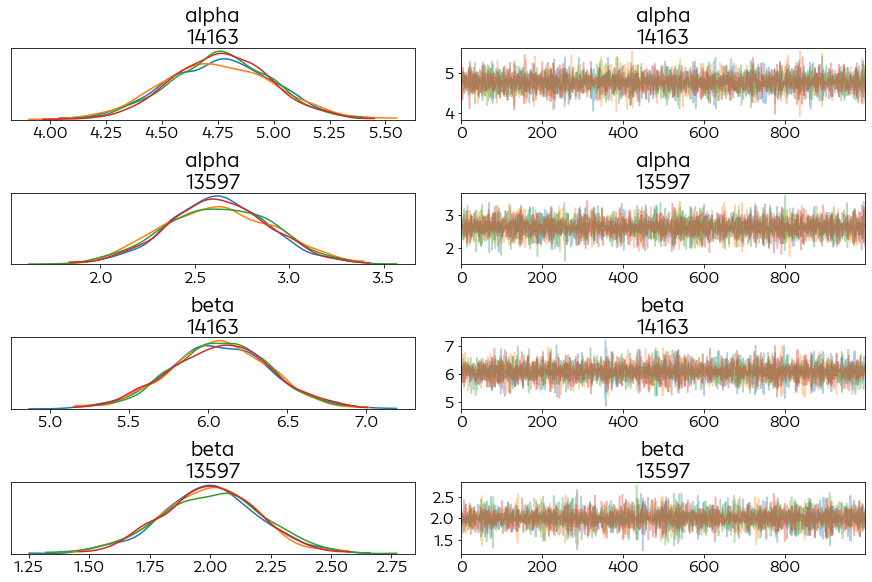

In [10]:
az.plot_trace(data, var_names=["alpha", 'beta'], 
              coords={"zip_code": [zip_codes[205], zip_codes[191]]})
plt.show()

Compare this with the bad model, a huge bunch of parameters have a very Rhat! Not very good!

The following parameters have an Rhat greater 1.01:
['mu_alpha', 'mu_beta', 'alpha[0]', 'alpha[1]', 'alpha[2]', 'alpha[3]', 'alpha[4]', 'alpha[5]', 'alpha[6]', 'alpha[7]', 'alpha[8]', 'alpha[9]', 'alpha[10]', 'alpha[11]', 'alpha[12]', 'alpha[13]', 'alpha[14]', 'alpha[15]', 'alpha[16]', 'alpha[18]', 'alpha[19]', 'alpha[20]', 'alpha[21]', 'alpha[22]', 'alpha[23]', 'alpha[24]', 'alpha[26]', 'alpha[27]', 'alpha[28]', 'alpha[29]', 'alpha[30]', 'alpha[32]', 'alpha[34]', 'alpha[35]', 'alpha[36]', 'alpha[37]', 'alpha[38]', 'alpha[39]', 'alpha[40]', 'alpha[45]', 'alpha[46]', 'alpha[47]', 'alpha[48]', 'alpha[50]', 'alpha[51]', 'alpha[52]', 'alpha[53]', 'alpha[54]', 'alpha[56]', 'alpha[57]', 'alpha[60]', 'alpha[61]', 'alpha[62]', 'alpha[63]', 'alpha[64]', 'alpha[65]', 'alpha[66]', 'alpha[68]', 'alpha[69]', 'alpha[72]', 'alpha[73]', 'alpha[74]', 'alpha[75]', 'alpha[77]', 'alpha[78]', 'alpha[79]', 'alpha[80]', 'alpha[82]', 'alpha[83]', 'alpha[88]', 'alpha[89]', 'alpha[90]', 'alpha[91]', 'alpha[92]'

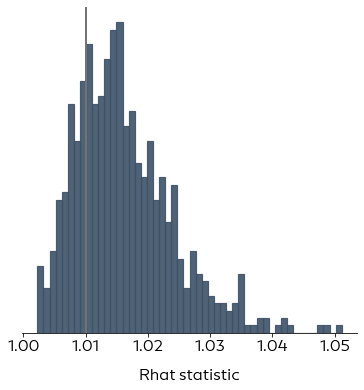

In [11]:
check_rhat(bad_data, threshold=1.01)
plt.show()

## Number of effective samples
Since the samples coming from one chain are usually autocorrelated. This means, the posterior sample we get is not an independent sample of the posterior distribution. The ESS, Effective sample size, estimates how many independent draws we roughly have in our sample. 
If the number of effective samples is very low (e.g. less than 10%) compared to the number of iterations (size of the posterior sample), then there might be a problem with our model. 

Note that it depends on your use case how many effective samples you need. If you only want to estimate the mean and median of the posterior distribution, then ~300 effective samples can be enough. If however you want to estimate very high or low percentiles, you will need much more.

For a bit more about the maths behind it, check this [section](https://mc-stan.org/docs/2_20/reference-manual/effective-sample-size-section.html).

I build a similr convenience function for the ESS:

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



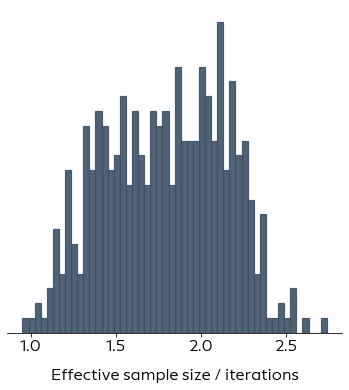

In [12]:
check_neff(data, threshold=0.1)
plt.show()

## Monte Carlo Standard Error
The Monte Carlo standard error is given by the posterior standard deviation divided by the square root of the number of effective samples. The smaller the standard error, the closer the posterior mean is expected to be to the true value. This standard error should not be greater than 10% of the posterior standard deviation.
For more details, check e.g. the [Stan user manual](https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html).

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None



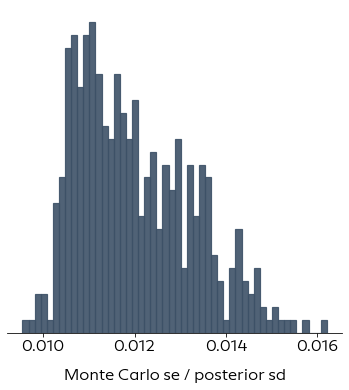

In [13]:
check_mcse(data)
plt.show()

# Some bad examples
In the next section, I fit a few models that have not converged, just to show how this looks like in the convergence diagnostics.

In [14]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(tune=50, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 1100/1100 [00:03<00:00, 292.21draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9612063297357322, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


This model has only been tuned for a very short time and this leads to various convergence problems. PyMC itself warns us that the Rhat (here called Gelman-Rubin statistic) is large and that the number of effective samples is very small. Also there were quite many divergences.

We also see this in the trace plots:

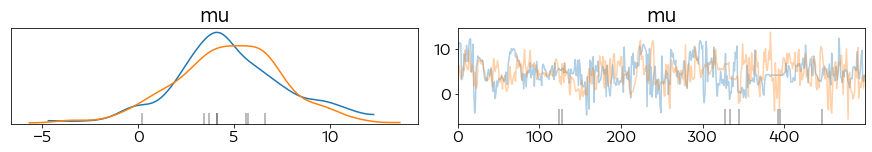

In [15]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

Increasing the tuning steps leads to less divergences and less warnings, but there are still many problems with this model.

In [16]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(tune=500, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 662.92draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39444060239710466, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


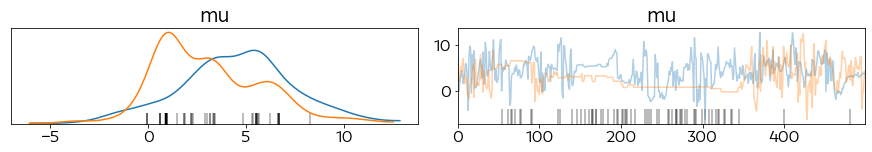

In [17]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

We can see in the trace plots that the chains did not explore the posterior space well and that there is high autocorrelation. We can plot the autocorrelation:

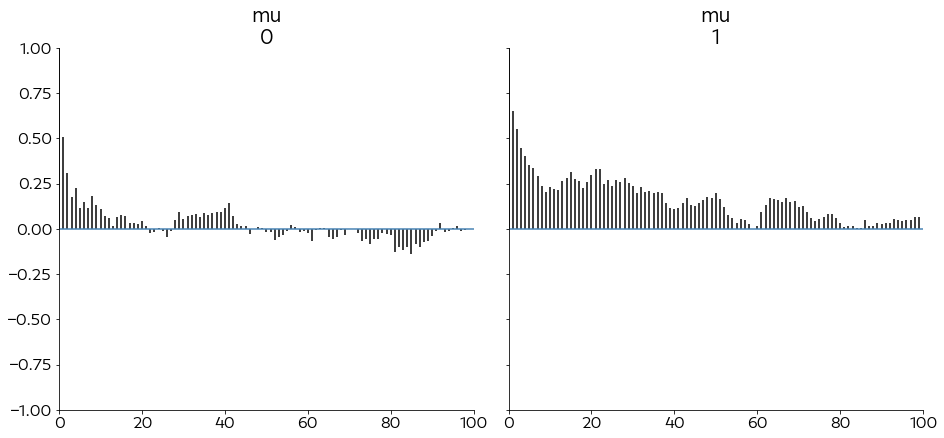

In [18]:
axes = az.plot_autocorr(posterior, var_names=["mu"], figsize=(13,6))
for axe in axes:
    for ax in axe:
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
plt.show()

For comparison, a model with low autocorrelation looks like this:

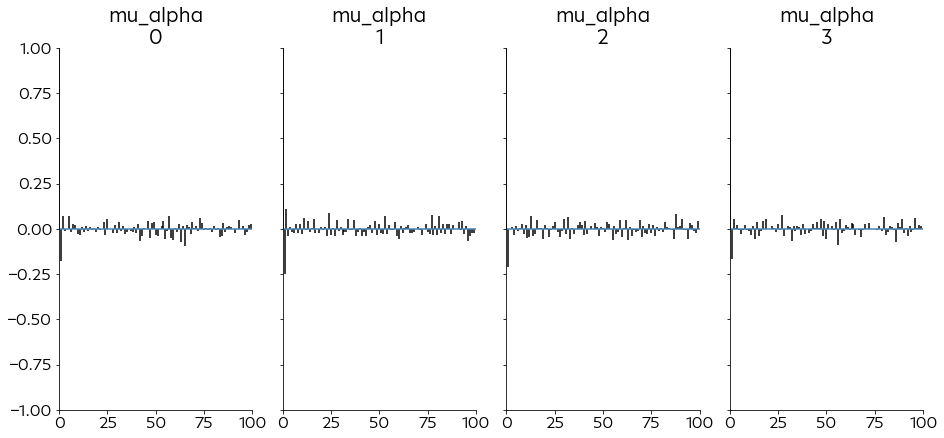

In [19]:
axes = az.plot_autocorr(data, var_names=["mu_alpha"], figsize=(13,6))
for axe in axes:
    for ax in axe:
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
plt.show()

The model above is the classic example of where a centered parametrization is problematic. 
We thus try a non-centered parametrization:

In [20]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(target_accept=0.9, draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_t, tau, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1140.77draws/s]


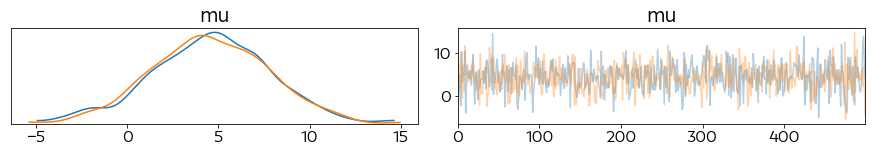

In [21]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

Now, the trace plot looks much better.

The trace plots for the bad model:

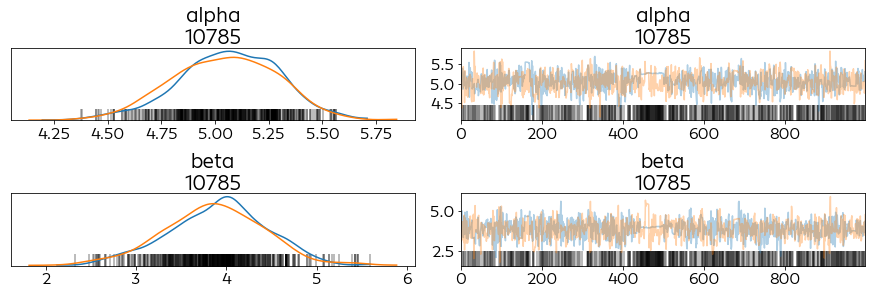

In [22]:
az.plot_trace(bad_data, var_names=['alpha', "beta"], coords={"zip_code": [zip_codes[54]],
                                                    "chain": [0,1]})
plt.show()